# Import libraries

In [9]:
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from eli5 import show_weights, show_prediction
import seaborn as sns
from sklearn.manifold import TSNE
import os
import pandas as pd

#custom
from py.helper import DataProcessing
from py.ml_metrics import evaluate_model, multiclass_logloss
from py.plotting import plot_tsne


In [10]:
# set K-mer length here
kmer = 4


In [11]:
rvdb14 = DataProcessing('RVDB14_complete_coronavirus_fixed.fasta', 'RVDB14_Coronavirus_meta_data_human_pathogen.csv')

# Load cleaned data

In [12]:
cleaned_path = os.path.join(rvdb14.data_path, 'RVDB14_complete_coronavirus_fixed.fasta.csv')

cleaned_df = pd.read_csv(cleaned_path, dtype={'label':int})
# remove nans
cleaned_df.dropna(inplace=True)

# remove artifacts
for index, row in cleaned_df.iterrows():
    if row['label'] < 0:
        cleaned_df.drop(index, inplace=True)
cleanded_df = cleaned_df[cleaned_df['label'] >= 0]
cleaned_df.head()

,seq,id,description,label,accession
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1


Labels found: [0 1]


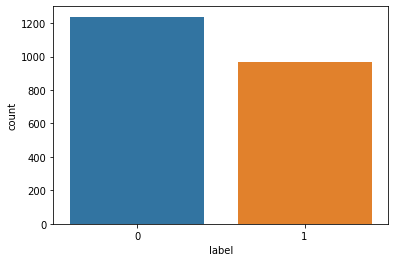

In [13]:
# biinary labels - sanity check 

print(f"Labels found: {cleaned_df['label'].unique()}")
sns.countplot(cleaned_df['label'])

In [14]:
# min and max length of sequences
max_len = max(len(s) for s in cleaned_df['seq'])
min_len =min(len(s) for s in cleaned_df['seq'])
print(f"Sequence length - max:{max_len}, min:{min_len}")

Sequence length - max:31775, min:25320


In [16]:
#make kmers
def get_kmer(row, k):
    return [row[i:i+k] for i in range(0, len(row), k)]


cleaned_df['kmers'] = cleaned_df['seq'].apply(get_kmer, args=(kmer,))
cleaned_df.head()

,seq,id,description,label,accession,kmers
0,ACTTTTAAAGATAAGTGAGTGTAGCGTAGCTGCCTACTTTCTTTAA...,acc|REFSEQ|NC_030292.1|Ferret,acc|REFSEQ|NC_030292.1|Ferret coronavirus isol...,0,NC_030292.1,"[ACTT, TTAA, AGAT, AAGT, GAGT, GTAG, CGTA, GCT..."
1,ACTTAAGTGTCTTATCTATCTATAGATAGAAAAGTCGCTTTTTAGA...,acc|REFSEQ|NC_028752.1|Camel,acc|REFSEQ|NC_028752.1|Camel alphacoronavirus ...,1,NC_028752.1,"[ACTT, AAGT, GTCT, TATC, TATC, TATA, GATA, GAA..."
2,AGTAAAGTGAGTGTAGCGTGGCTATATCTCTTCTTTTACTTTAACT...,acc|REFSEQ|NC_028806.1|Swine,acc|REFSEQ|NC_028806.1|Swine enteric coronavir...,1,NC_028806.1,"[AGTA, AAGT, GAGT, GTAG, CGTG, GCTA, TATC, TCT..."
3,AAGTGTCGTGCTCCTAGGGGTTGCACTTGACGTGTTCCGTCACGTA...,"acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012,","acc|REFSEQ|NC_028824.1|BtRf-AlphaCoV_YN2012, a...",0,NC_028824.1,"[AAGT, GTCG, TGCT, CCTA, GGGG, TTGC, ACTT, GAC..."
4,GGCCCCCATGGCTAGCAACCGTATTTCGTTGGCTTTTGCCAATGAT...,"acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013,","acc|REFSEQ|NC_028814.1|BtRf-AlphaCoV_HuB2013, ...",1,NC_028814.1,"[GGCC, CCCA, TGGC, TAGC, AACC, GTAT, TTCG, TTG..."


In [24]:
# find letter representations
kmers = []
[kmers.extend(i) for i in  cleaned_df['kmers']]
min_len = min([len(i) for i in cleaned_df['kmers']])
len_kmers = len(set(kmers)) # unique kmers
print(f'Number of unique kmers:{len_kmers}, min length of kmer arr: {min_len}')
# sns.countplot(kmers)

Number of unique kmers:1310, min length of kmer arr: 6330


# deep learning with convolutional neural nets
# kmers


In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from numpy import array
import itertools

# The LabelEncoder encodes a sequence of residues as a sequence of integers.
integer_encoder = LabelEncoder()
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')

#fit one-hot encorder with all neucleotides
integer_cat_arr = np.array(list(range(len_kmers))).reshape(-1, 1)
one_hot_encoder = one_hot_encoder.fit(integer_cat_arr)
sequences = [i[:min_len] for i in cleaned_df['kmers']]

#fit the label encoder with all the nucleotides
integer_encoder = integer_encoder.fit(list(itertools.chain.from_iterable(sequences)))
input_features = []
int_encoded = [] # for LSTM

for sequence in sequences:
  integer_encoded = integer_encoder.transform(sequence)
  int_encoded.append(integer_encoded)
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

int_encoded = array(int_encoded)
print(int_encoded)
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('nucleotude Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

In [22]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(cleaned_df['label']).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)
input_labels.shape

Labels:
 [[0 1 1 ... 1 0 0]]
One-hot encoded labels:
 [[1. 0. 0. ... 0. 1. 1.]
 [0. 1. 1. ... 1. 0. 0.]]


(2206, 2)

In [23]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.2, random_state=42)

In [24]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3,input_shape=(train_features.shape[1], 13)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25318, 32)         1280      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6329, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 202528)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                3240464   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 3,241,778
Trainable params: 3,241,778
Non-trainable params: 0
_________________________________________________________________


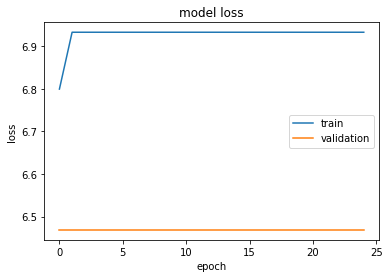

In [25]:
history = model.fit(train_features, train_labels, epochs=25, verbose=0, validation_split=0.25, shuffle=True)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

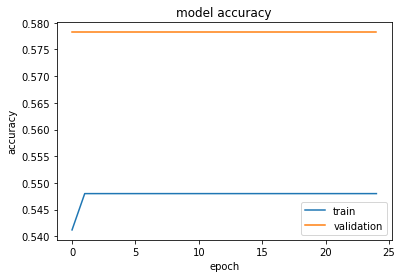

In [26]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Confusion matrix:
 [[258   0]
 [184   0]]


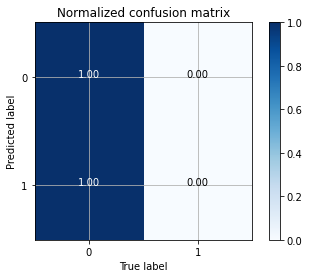

In [27]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

In [28]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [29]:
tf.__version__

'2.1.0'

In [30]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
import tensorflow.keras.backend as K

def compute_salient_residues(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = K.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=1),a_min=0, a_max=None)

In [36]:
sequence_index = 2  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_residues(model, input_features[sequence_index])

plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('C') for i in range(2, 6)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Amino Acids')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal)), list(sequences[sequence_index]));
plt.title('Saliency map for residues in one of the positive sequences'
          ' (green indicates the actual residue in motif)');
plt.show()

TypeError: object of type 'NoneType' has no len()

<Figure size 1152x360 with 0 Axes>